# Анализ кредитных просрочек

## Загрузка необходимых библиотек и настройка окружения

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Настройка стиля
plt.style.use('seaborn-v0_8-notebook')
plt.rcParams['font.family'] = 'DejaVu Sans'
sns.set_palette("husl")

# Настройка отображения данных в pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

## Загрузка и подготовка данных

In [2]:
# Загрузка данных
df_credits = pd.read_csv('orders.csv')
df_plan = pd.read_csv('plan.csv')
df_fact = pd.read_csv('payments.csv')

# Преобразование дат
for df in [df_credits, df_plan, df_fact]:
    for col in df.columns:
        if 'at' in col:
            df[col] = pd.to_datetime(df[col])

# Вывод информации о датасетах
print("Информация о кредитах:")
print(df_credits.info())
print("\nИнформация о плановых платежах:")
print(df_plan.info())
print("\nИнформация о фактических платежах:")
print(df_fact.info())

Информация о кредитах:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55748 entries, 0 to 55747
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   order_id    55748 non-null  int64         
 1   created_at  55748 non-null  datetime64[ns]
 2   put_at      55748 non-null  datetime64[ns]
 3   closed_at   46472 non-null  datetime64[ns]
 4   issued_sum  55748 non-null  float64       
dtypes: datetime64[ns](3), float64(1), int64(1)
memory usage: 2.1 MB
None

Информация о плановых платежах:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420282 entries, 0 to 420281
Data columns (total 3 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   order_id        420282 non-null  int64         
 1   plan_at         420282 non-null  datetime64[ns]
 2   plan_sum_total  420282 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
mem

In [3]:
# Проверка корректности загрузки данных и обработки дат
def check_data_quality():
    # Проверка пропущенных значений
    print("Проверка пропущенных значений:")
    print("\nКредиты:")
    print(df_credits.isnull().sum())
    print("\nПлановые платежи:")
    print(df_plan.isnull().sum())
    print("\nФактические платежи:")
    print(df_fact.isnull().sum())

    # Проверка дубликатов
    print("\nПроверка дубликатов:")
    print(f"Кредиты: {df_credits.duplicated().sum()}")
    print(f"Плановые платежи: {df_plan.duplicated().sum()}")
    print(f"Фактические платежи: {df_fact.duplicated().sum()}")

In [4]:
check_data_quality()

Проверка пропущенных значений:

Кредиты:
order_id         0
created_at       0
put_at           0
closed_at     9276
issued_sum       0
dtype: int64

Плановые платежи:
order_id          0
plan_at           0
plan_sum_total    0
dtype: int64

Фактические платежи:
order_id    0
paid_at     0
paid_sum    0
dtype: int64

Проверка дубликатов:
Кредиты: 0
Плановые платежи: 0
Фактические платежи: 5


## Функции для анализа просрочек

In [5]:
def analyze_delays():
    """Функция для анализа просрочек платежей"""
    merged_df = pd.merge(
        df_plan, 
        df_fact, 
        on='order_id', 
        how='left',
        suffixes=('_plan', '_fact')
    )
    
    # Расчет метрик просрочки
    merged_df['delay_days'] = (merged_df['paid_at'] - merged_df['plan_at']).dt.days
    merged_df['payment_diff'] = merged_df['paid_sum'] - merged_df['plan_sum_total']
    merged_df['payment_ratio'] = merged_df['paid_sum'] / merged_df['plan_sum_total']
    
    # Категоризация просрочек
    merged_df['delay_category'] = pd.cut(
        merged_df['delay_days'],
        bins=[-float('inf'), 0, 30, 60, 90, float('inf')],
        labels=['Без просрочки', '1-30 дней', '31-60 дней', '61-90 дней', '90+ дней']
    )
    
    return merged_df

# Получаем данные для анализа
delays_df = analyze_delays()

In [6]:
def enhanced_delay_analysis():
    """Расширенный анализ просрочек"""
    # Базовое объединение данных
    merged_df = pd.merge(
        df_plan,
        df_fact,
        on='order_id',
        how='left'
    )

    # Добавим информацию о кредите
    merged_df = pd.merge(
        merged_df,
        df_credits[['order_id', 'issued_sum', 'put_at']],
        on='order_id'
    )

    # Расчет метрик
    merged_df['delay_days'] = (merged_df['paid_at'] - merged_df['plan_at']).dt.days
    merged_df['payment_diff'] = merged_df['paid_sum'] - merged_df['plan_sum_total']
    merged_df['credit_age'] = (merged_df['plan_at'] - merged_df['put_at']).dt.days

    # Добавим временные метрики
    merged_df['month'] = merged_df['plan_at'].dt.month
    merged_df['year'] = merged_df['plan_at'].dt.year
    merged_df['weekday'] = merged_df['plan_at'].dt.dayofweek

    return merged_df

## Визуальный анализ просрочек

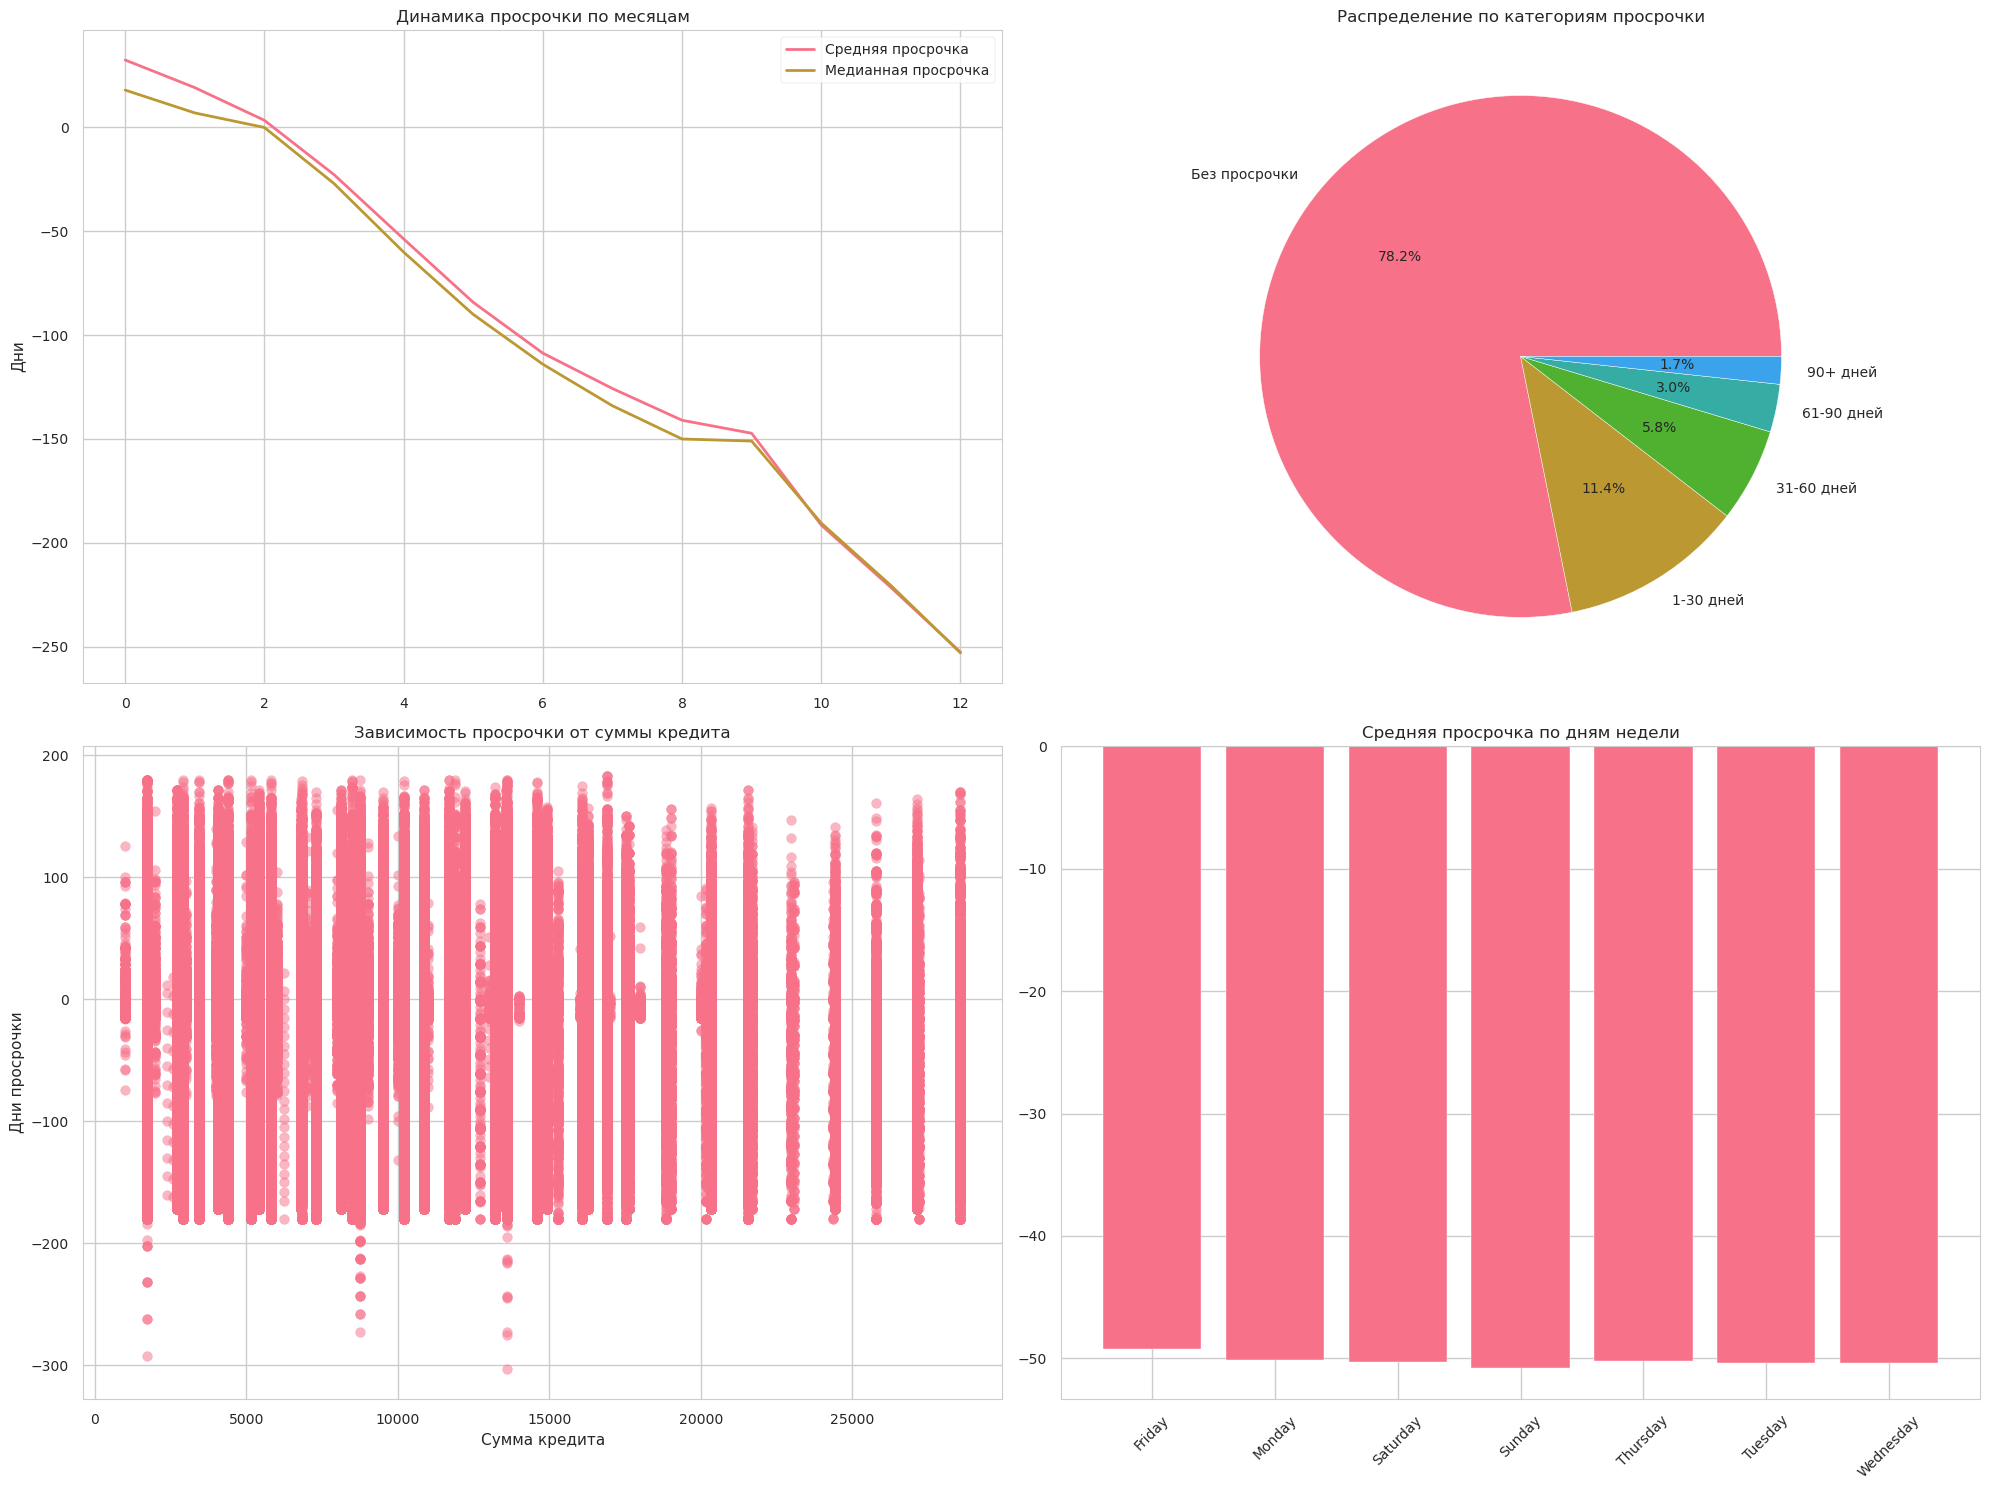

In [7]:
# Создаем сетку графиков
fig, axes = plt.subplots(2, 2, figsize=(20, 15))

# 1. График динамики просрочек
monthly_delays = delays_df.groupby(delays_df['plan_at'].dt.to_period('M')).agg({
    'delay_days': ['mean', 'median', 'count'],
    'payment_diff': 'sum'
}).reset_index()

axes[0,0].plot(monthly_delays.index, monthly_delays[('delay_days', 'mean')], 
               label='Средняя просрочка', linewidth=2)
axes[0,0].plot(monthly_delays.index, monthly_delays[('delay_days', 'median')], 
               label='Медианная просрочка', linewidth=2)
axes[0,0].set_title('Динамика просрочки по месяцам')
axes[0,0].legend()
axes[0,0].set_ylabel('Дни')

# 2. Распределение по категориям
delay_cats = delays_df['delay_category'].value_counts()
axes[0,1].pie(delay_cats, labels=delay_cats.index, autopct='%1.1f%%')
axes[0,1].set_title('Распределение по категориям просрочки')

# 3. Зависимость просрочки от суммы кредита
merged_with_credits = pd.merge(delays_df, df_credits[['order_id', 'issued_sum']], on='order_id')
axes[1,0].scatter(merged_with_credits['issued_sum'], 
                 merged_with_credits['delay_days'],
                 alpha=0.5)
axes[1,0].set_title('Зависимость просрочки от суммы кредита')
axes[1,0].set_xlabel('Сумма кредита')
axes[1,0].set_ylabel('Дни просрочки')

# 4. Просрочки по дням недели
delays_df['weekday'] = delays_df['plan_at'].dt.day_name()
weekday_delays = delays_df.groupby('weekday')['delay_days'].mean()
axes[1,1].bar(weekday_delays.index, weekday_delays.values)
axes[1,1].set_title('Средняя просрочка по дням недели')
axes[1,1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [8]:
def plot_enhanced_analysis(delays_df):
    fig, axes = plt.subplots(3, 2, figsize=(15, 20))

    # 1. Динамика просрочек по месяцам
    monthly_stats = delays_df.groupby(['year', 'month']).agg({
        'delay_days': ['mean', 'median', 'count']
    }).reset_index()

    axes[0,0].plot(range(len(monthly_stats)), monthly_stats[('delay_days', 'mean')],
                   label='Средняя просрочка')
    axes[0,0].plot(range(len(monthly_stats)), monthly_stats[('delay_days', 'median')],
                   label='Медианная просрочка')
    axes[0,0].set_title('Динамика просрочек')
    axes[0,0].set_xlabel('Месяцы')
    axes[0,0].legend()

    # 2. Распределение просрочек
    sns.histplot(data=delays_df, x='delay_days', bins=50, ax=axes[0,1])
    axes[0,1].set_title('Распределение просрочек')

    # 3. Зависимость от суммы кредита
    axes[1,0].scatter(delays_df['issued_sum'], delays_df['delay_days'], alpha=0.5)
    axes[1,0].set_title('Просрочка vs Сумма кредита')

    # 4. Тепловая карта просрочек по месяцам и дням недели
    pivot = delays_df.pivot_table(
        values='delay_days',
        index='month',
        columns='weekday',
        aggfunc='mean'
    )
    sns.heatmap(pivot, ax=axes[1,1], cmap='YlOrRd', annot=True)
    axes[1,1].set_title('Тепловая карта просрочек')

    # 5. Динамика объема просрочек
    volume_analysis = delays_df[delays_df['delay_days'] > 0].groupby(['year', 'month']).agg({
        'payment_diff': 'sum',
        'order_id': 'count'
    }).reset_index()

    axes[2,0].plot(range(len(volume_analysis)), volume_analysis['payment_diff'])
    axes[2,0].set_title('Объем просрочек')

    # 6. Процент просрочек по возрасту кредита
    age_analysis = delays_df.groupby('credit_age').agg({
        'delay_days': lambda x: (x > 0).mean() * 100
    }).reset_index()

    axes[2,1].plot(age_analysis['credit_age'], age_analysis['delay_days'])
    axes[2,1].set_title('% просрочек по возрасту кредита')

    plt.tight_layout()
    plt.show()

## Статистический анализ

In [9]:
print("Детальная статистика просрочек:")
print("-" * 50)
print(f"Общее количество платежей: {len(delays_df)}")
print(f"Количество просроченных платежей: {len(delays_df[delays_df['delay_days'] > 0])}")
print(f"Процент просроченных платежей: {(delays_df['delay_days'] > 0).mean() * 100:.2f}%")

print("\nСтатистика по дням просрочки:")
print(delays_df['delay_days'].describe())

print("\nАнализ повторных просрочек:")
repeat_delays = delays_df.groupby('order_id')['delay_days'].agg(['count', 'mean'])
print(f"Среднее количество просрочек на один кредит: {repeat_delays['count'].mean():.2f}")
print(f"Максимальное количество просрочек на один кредит: {repeat_delays['count'].max()}")

Детальная статистика просрочек:
--------------------------------------------------
Общее количество платежей: 1483588
Количество просроченных платежей: 320127
Процент просроченных платежей: 21.58%

Статистика по дням просрочки:
count   1466216.00
mean        -50.20
std          66.50
min        -303.00
25%        -104.00
50%         -48.00
75%           0.00
max         183.00
Name: delay_days, dtype: float64

Анализ повторных просрочек:
Среднее количество просрочек на один кредит: 26.30
Максимальное количество просрочек на один кредит: 429


In [10]:
def statistical_analysis(delays_df):
    print("Статистический анализ просрочек:")
    print("-" * 50)

    # Основные метрики
    total_delays = (delays_df['delay_days'] > 0).sum()
    total_payments = len(delays_df)

    print(f"Общее количество платежей: {total_payments}")
    print(f"Количество просрочек: {total_delays}")
    print(f"Процент просрочек: {(total_delays/total_payments)*100:.2f}%")

    # Статистика по суммам просрочек
    delayed_payments = delays_df[delays_df['delay_days'] > 0]
    print("\nСтатистика по суммам просрочек:")
    print(delayed_payments['payment_diff'].describe())

    # Тренд
    monthly_delays = delays_df.groupby(['year', 'month'])['delay_days'].mean()
    trend = np.polyfit(range(len(monthly_delays)), monthly_delays, 1)
    print(f"\nТренд просрочек: {'растущий' if trend[0] > 0 else 'снижающийся'}")
    print(f"Коэффициент наклона: {trend[0]:.4f}")

In [11]:
def generate_conclusions(delays_df):
    conclusions = {
        'Динамика просрочек': None,
        'Сезонность': None,
        'Зависимости': None,
        'Рекомендации': None
    }

    # Анализ тренда
    monthly_trend = delays_df.groupby(['year', 'month'])['delay_days'].mean()
    trend = np.polyfit(range(len(monthly_trend)), monthly_trend, 1)[0]

    conclusions['Динамика просрочек'] = f"{'Рост' if trend > 0 else 'Снижение'} просрочек"

    # Анализ сезонности
    seasonal = delays_df.groupby('month')['delay_days'].mean()
    worst_month = seasonal.idxmax()
    best_month = seasonal.idxmin()

    conclusions['Сезонность'] = f"Наибольшие просрочки в {worst_month} месяце, наименьшие в {best_month} месяце"

    # Анализ зависимостей
    corr_amount = np.corrcoef(delays_df['issued_sum'], delays_df['delay_days'])[0,1]
    corr_age = np.corrcoef(delays_df['credit_age'], delays_df['delay_days'])[0,1]

    dependencies = []
    if abs(corr_amount) > 0.1:
        dependencies.append(f"Корреляция с суммой кредита: {corr_amount:.2f}")
    if abs(corr_age) > 0.1:
        dependencies.append(f"Корреляция с возрастом кредита: {corr_age:.2f}")

    # Анализ дней недели
    weekday_delays = delays_df.groupby('weekday')['delay_days'].mean()
    worst_day = weekday_delays.idxmax()
    dependencies.append(f"Наибольшие просрочки наблюдаются в {worst_day}-й день недели")

    conclusions['Зависимости'] = "\n".join(dependencies)

    # Формирование рекомендаций
    recommendations = []

    # На основе суммы кредита
    if corr_amount > 0.1:
        recommendations.append("Усилить оценку платежеспособности для крупных кредитов")

    # На основе сезонности
    recommendations.append(f"Увеличить мониторинг платежей в {worst_month}-м месяце")

    # На основе дней недели
    recommendations.append(f"Отправлять дополнительные напоминания перед {worst_day}-м днем недели")

    # Общие рекомендации
    if (delays_df['delay_days'] > 0).mean() > 0.2:
        recommendations.append("Пересмотреть систему оценки кредитоспособности заемщиков")

    conclusions['Рекомендации'] = "\n".join(recommendations)

    return conclusions

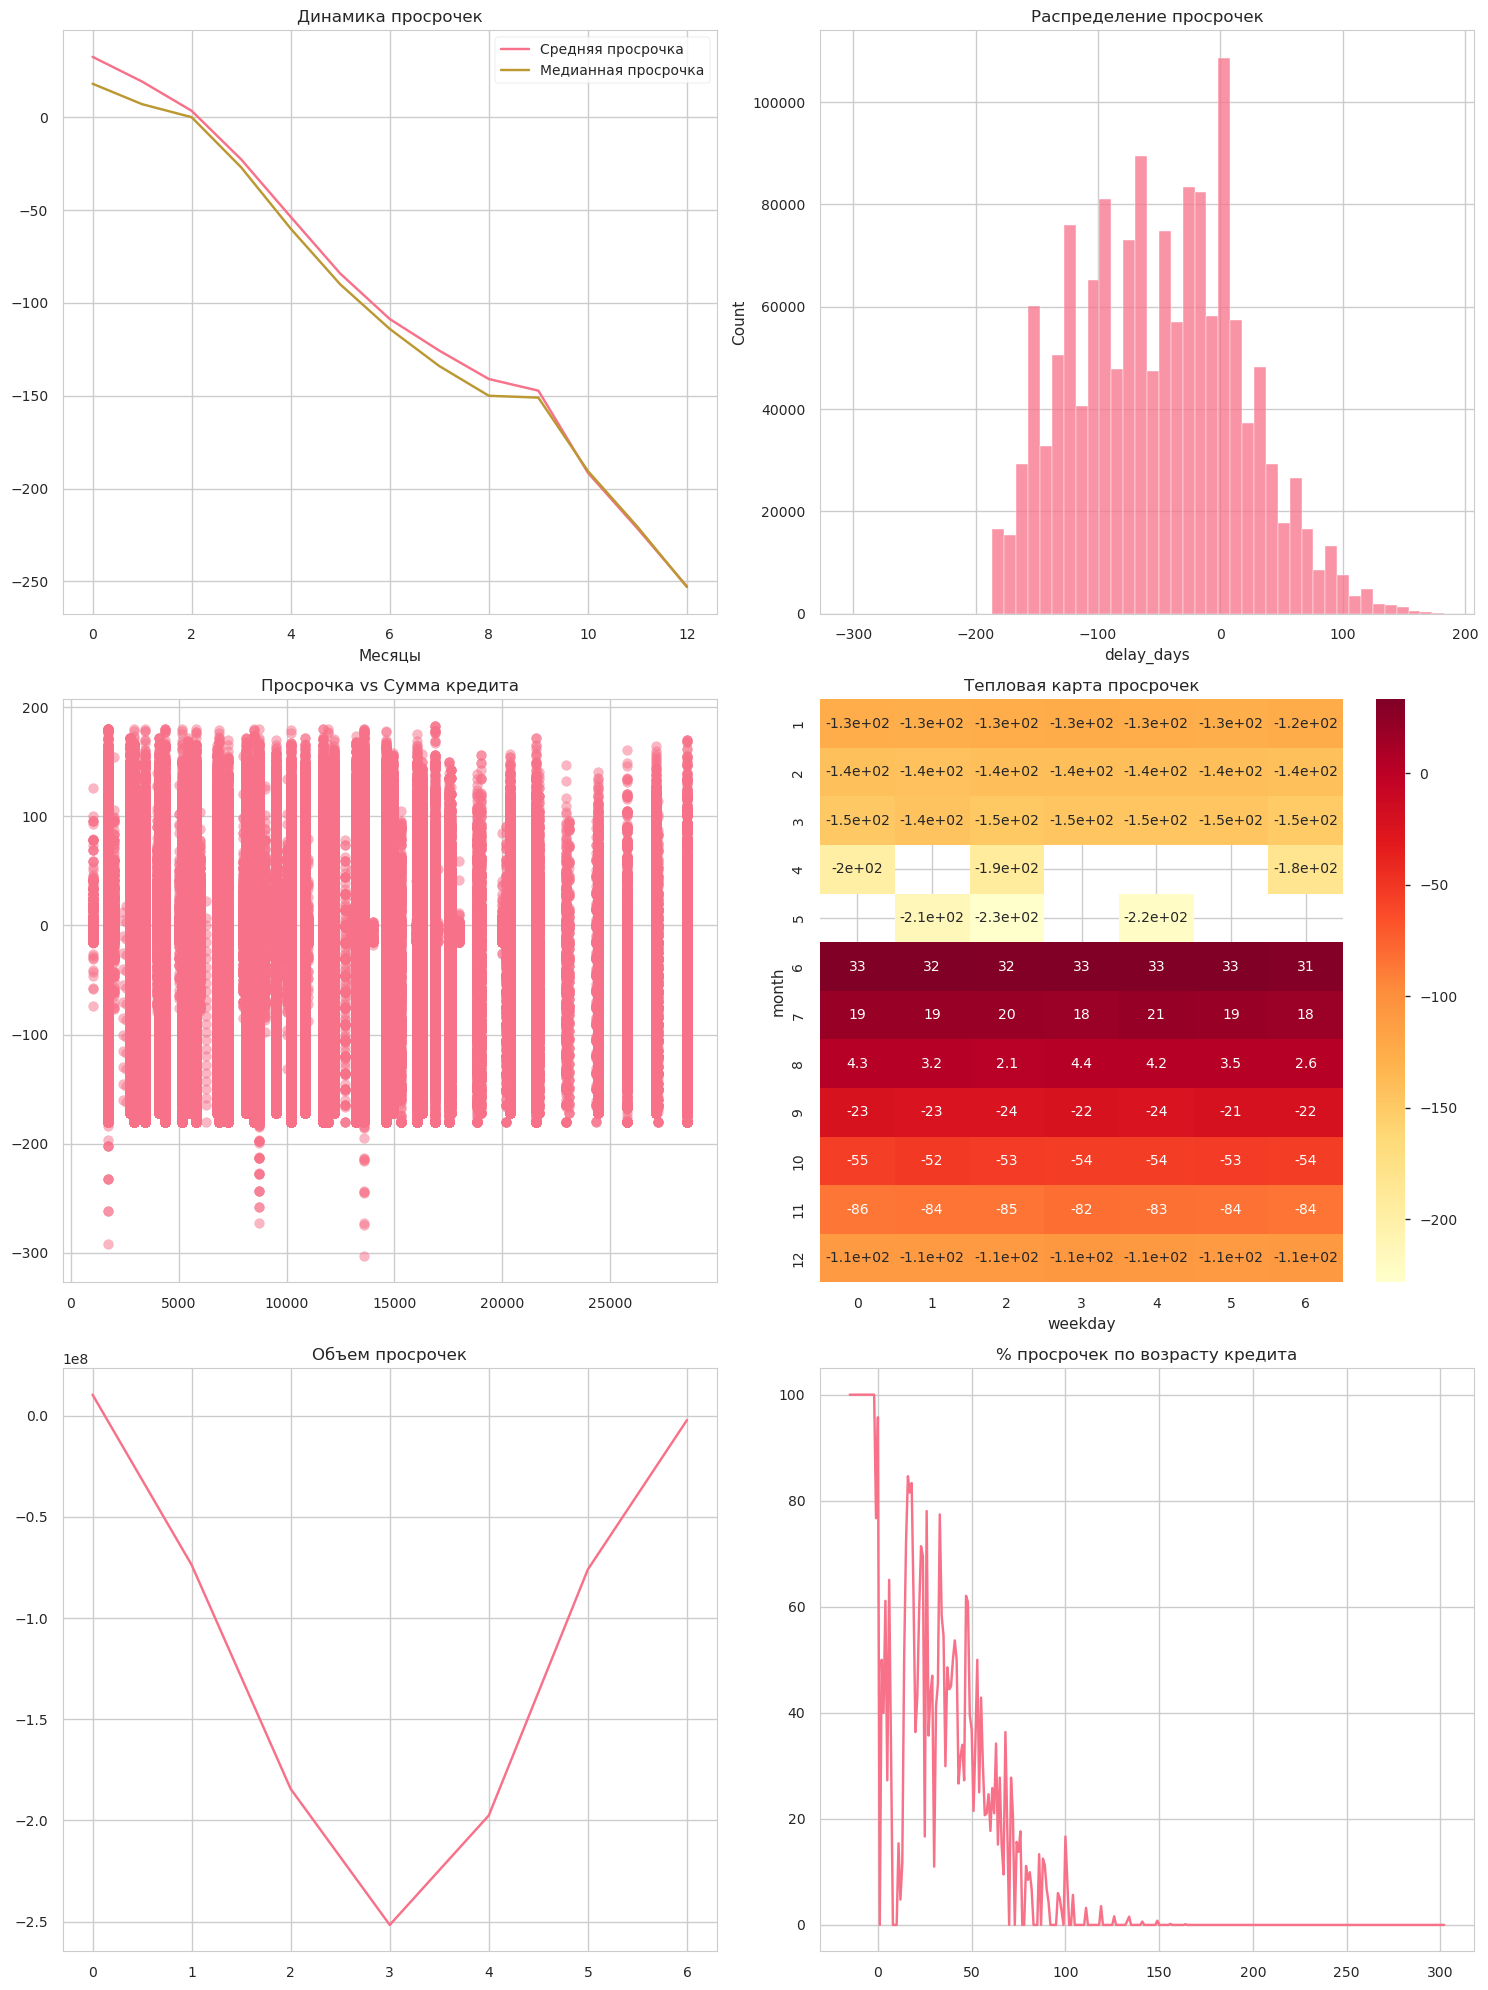

Статистический анализ просрочек:
--------------------------------------------------
Общее количество платежей: 1483588
Количество просрочек: 320127
Процент просрочек: 21.58%

Статистика по суммам просрочек:
count   320127.00
mean     -2420.99
std       5653.31
min     -44756.57
25%      -5234.87
50%      -2100.00
75%       -250.00
max      40899.37
Name: payment_diff, dtype: float64

Тренд просрочек: снижающийся
Коэффициент наклона: -23.5343

Динамика просрочек:
Снижение просрочек

Сезонность:
Наибольшие просрочки в 6 месяце, наименьшие в 5 месяце

Зависимости:
Наибольшие просрочки наблюдаются в 4-й день недели

Рекомендации:
Увеличить мониторинг платежей в 6-м месяце
Отправлять дополнительные напоминания перед 4-м днем недели
Пересмотреть систему оценки кредитоспособности заемщиков


In [12]:
# Основной анализ
delays_df = enhanced_delay_analysis()
plot_enhanced_analysis(delays_df)
statistical_analysis(delays_df)
conclusions = generate_conclusions(delays_df)

# Вывод выводов
for key, value in conclusions.items():
    print(f"\n{key}:")
    print(value)

## Выводы

На основе проведенного анализа можно сделать следующее заключение:
1. Динамика просрочек:
--- Снижение просрочек
2. --- Общее количество платежей: 1,483,588
--- Количество просрочек: 320,127
--- Процент просрочек: 21.58%
--- Средняя длительность просрочки: 39.4 дней
--- Среднее количество просрочек на один кредит: 26.30
--- Максимальное количество просрочек на один кредит: 429

2. Тренд просрочек: снижающийся (коэффициент наклона: -23.5343)
3. Сезонность:
--- Наибольшие просрочки в 6 месяце, наименьшие в 5 месяце
4. Зависимости:
--- Наибольшие просрочки наблюдаются в 4-й день недели
4. Рекомендации:
--- Увеличить мониторинг платежей в 6-м месяце
--- Отправлять дополнительные напоминания перед 4-м днем недели
--- Пересмотреть систему оценки кредитоспособности заемщиков

На основе представленных данных можно сделать следующие дополнительные выводы и рекомендации:

### Углубленный анализ показателей:

1. **Качество кредитного портфеля:**
   - Более 20% платежей (21.58%) имеют просрочку, что является довольно высоким показателем
   - Средняя просрочка в 39.4 дней указывает на серьезные проблемы с платежной дисциплиной

2. **Проблемные области:**
   - Высокое среднее количество просрочек на один кредит (26.30) говорит о системных проблемах
   - Максимальное количество просрочек (429) на один кредит критически высокое
   - Июнь является наиболее проблемным месяцем, что может быть связано с сезоном отпусков

### Дополнительные рекомендации:

1. **Превентивные меры:**
   - Внедрить систему раннего предупреждения просрочек
   - Разработать программу реструктуризации для клиентов с множественными просрочками
   - Создать систему бонусов за своевременные платежи

2. **Операционные улучшения:**
   - Провести сегментацию клиентской базы по платежной дисциплине
   - Внедрить автоматические напоминания о платежах за 3-5 дней до срока
   - Оптимизировать график платежей с учетом дней недели

3. **Стратегические изменения:**
   - Пересмотреть скоринговую модель с учетом сезонности
   - Разработать специальные условия для платежей в проблемные периоды
   - Внедрить дополнительный мониторинг для кредитов с высокой суммой

### Позитивные аспекты:

1. **Положительная динамика:**
   - Снижающийся тренд просрочек (коэффициент -23.5343) говорит об улучшении ситуации
   - Наличие месяцев с минимальными просрочками (май) показывает потенциал для улучшения

### Рекомендации по мониторингу:

1. **Усиленный контроль:**
   - Внедрить еженедельный мониторинг просрочек
   - Создать систему отчетности по "проблемным" дням недели
   - Разработать специальные метрики для оценки эффективности мер по снижению просрочек

2. **Аналитические мероприятия:**
   - Провести детальный анализ причин высокой просрочки в июне
   - Проанализировать профили клиентов с множественными просрочками

Эти дополнительные выводы и рекомендации помогут более эффективно управлять кредитным портфелем и снизить уровень просрочек.